* YOLOv3 by chainercv
* See
    * https://arxiv.org/abs/1804.02767
    * https://pjreddie.com/darknet/yolo/
    * https://github.com/chainer/chainercv/tree/master/examples/yolo
* import Pascal VOC format dataset using chainercv

In [43]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import chainer
import chainercv
from chainercv.datasets import voc_bbox_label_names, VOCBboxDataset
from chainercv.visualizations import vis_bbox
from tqdm import tqdm

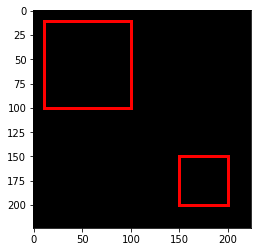

In [3]:
img = np.zeros((3, 224, 224), dtype=np.float32)
bbox = np.array([[10, 10, 100, 100], [150, 150, 200, 200]], dtype=np.float32)
vis_bbox(img, bbox)
plt.show()

In [5]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar -P ./data

--2018-09-08 00:07:56--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: './data/VOCtrainval_06-Nov-2007.tar'

VOCtrainval_06-Nov- 100%[===================>] 438.72M  6.89MB/s    in 68s     

2018-09-08 00:09:05 (6.44 MB/s) - './data/VOCtrainval_06-Nov-2007.tar' saved [460032000/460032000]



In [8]:
!tar -xf ./data/VOCtrainval_06-Nov-2007.tar -C ./data

In [9]:
!ls ./data/VOCdevkit/VOC2007/

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


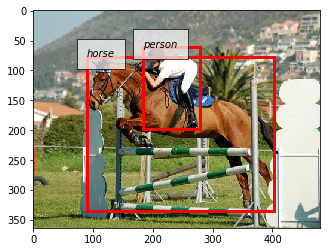

In [10]:
dataset = VOCBboxDataset(data_dir='./data/VOCdevkit/VOC2007')
img, bbox, label = dataset[1]
vis_bbox(img, bbox, label, label_names=voc_bbox_label_names)
plt.show()

From: https://chainercv-models.preferred.jp/yolo_v3_voc0712_converted_2018_05_01.npz
To: /root/.chainer/dataset/_dl_cache/79d417010adfc0e1052bb8e5c4851753
  %   Total    Recv       Speed  Time left
100  219MiB  219MiB   8808KiB/s    0:00:00

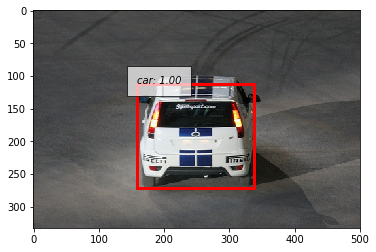

In [11]:
img, _, _ = dataset[0]
img = img[np.newaxis]

model = chainercv.links.YOLOv3(pretrained_model='voc0712')

bboxes, labels, scores = model.predict(img)

vis_bbox(img[0], bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
plt.show()

In [13]:
gpu = 0

if gpu >= 0:
    chainer.cuda.get_device_from_id(gpu).use()
    model.to_gpu()

valid_dataset = VOCBboxDataset(data_dir='./data/VOCdevkit/VOC2007', split='val')
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size=32, repeat=False, shuffle=False)

valid_iter.reset()
evaluator = chainercv.extensions.DetectionVOCEvaluator(valid_iter, model, label_names=voc_bbox_label_names)
result = evaluator()
result

{'main/map': 0.9564527034761123,
 'main/ap/aeroplane': 0.9804775869291997,
 'main/ap/bicycle': 0.9652365524633046,
 'main/ap/bird': 0.9539325355999033,
 'main/ap/boat': 0.9786820492160777,
 'main/ap/bottle': 0.878903793418407,
 'main/ap/bus': 0.963719783452012,
 'main/ap/car': 0.9495486298013353,
 'main/ap/cat': 0.9841265397536395,
 'main/ap/chair': 0.9432256243844747,
 'main/ap/cow': 0.9671469618979855,
 'main/ap/diningtable': 0.9702680990944399,
 'main/ap/dog': 0.9882202110740534,
 'main/ap/horse': 0.9610791826309067,
 'main/ap/motorbike': 0.9814845658449921,
 'main/ap/person': 0.9092149422492146,
 'main/ap/pottedplant': 0.9035379192577182,
 'main/ap/sheep': 0.8737691867545412,
 'main/ap/sofa': 0.989952105667997,
 'main/ap/train': 1.0,
 'main/ap/tvmonitor': 0.9865278000320464}

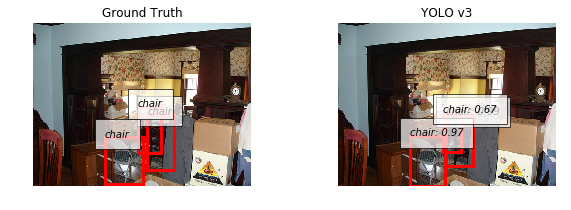

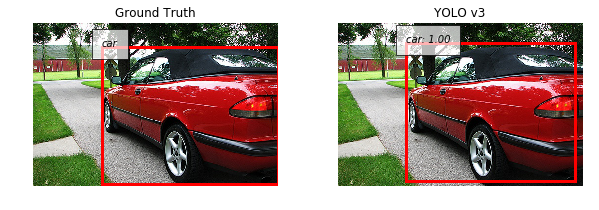

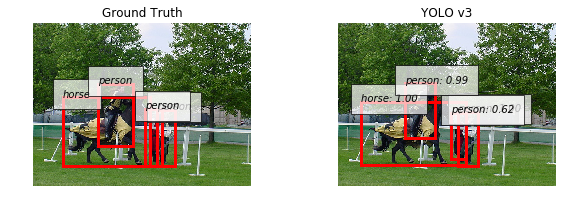

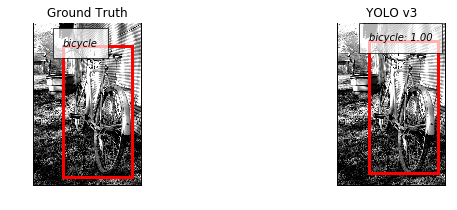

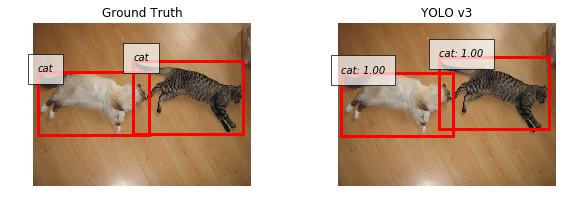

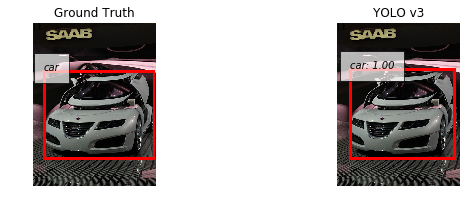

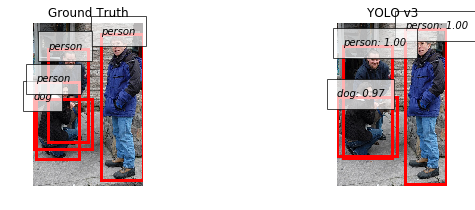

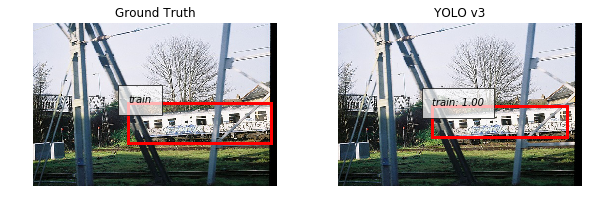

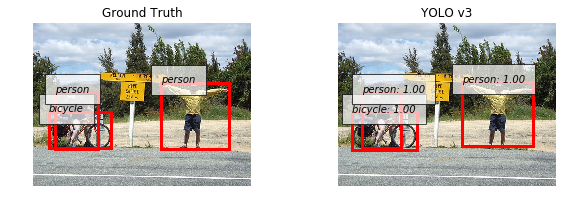

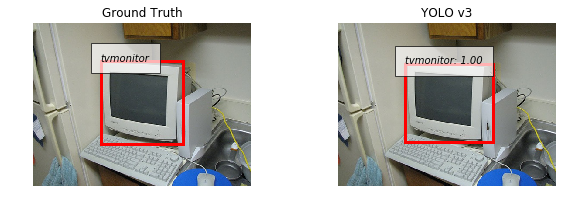

In [41]:
model.score_thresh = 0.3

for i in range(10):
    
    img, gt_bboxes, gt_labels = valid_dataset[i]
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    
    vis_bbox(img, gt_bboxes, gt_labels, label_names=voc_bbox_label_names, ax=axs[0])
    axs[0].axis('off')
    axs[0].set_title('Ground Truth')
    
    img = img[np.newaxis]
    
    pred_bboxes, pred_labels, pred_scores = model.predict(img)
    
    vis_bbox(img[0], pred_bboxes[0], pred_labels[0], pred_scores[0], label_names=voc_bbox_label_names, ax=axs[1])
    axs[1].axis('off')
    axs[1].set_title('YOLO v3')
    
    plt.show()

In [23]:
from chainercv.evaluations import calc_detection_voc_prec_rec, calc_detection_voc_ap

100%|██████████| 2510/2510 [07:37<00:00,  5.48it/s]


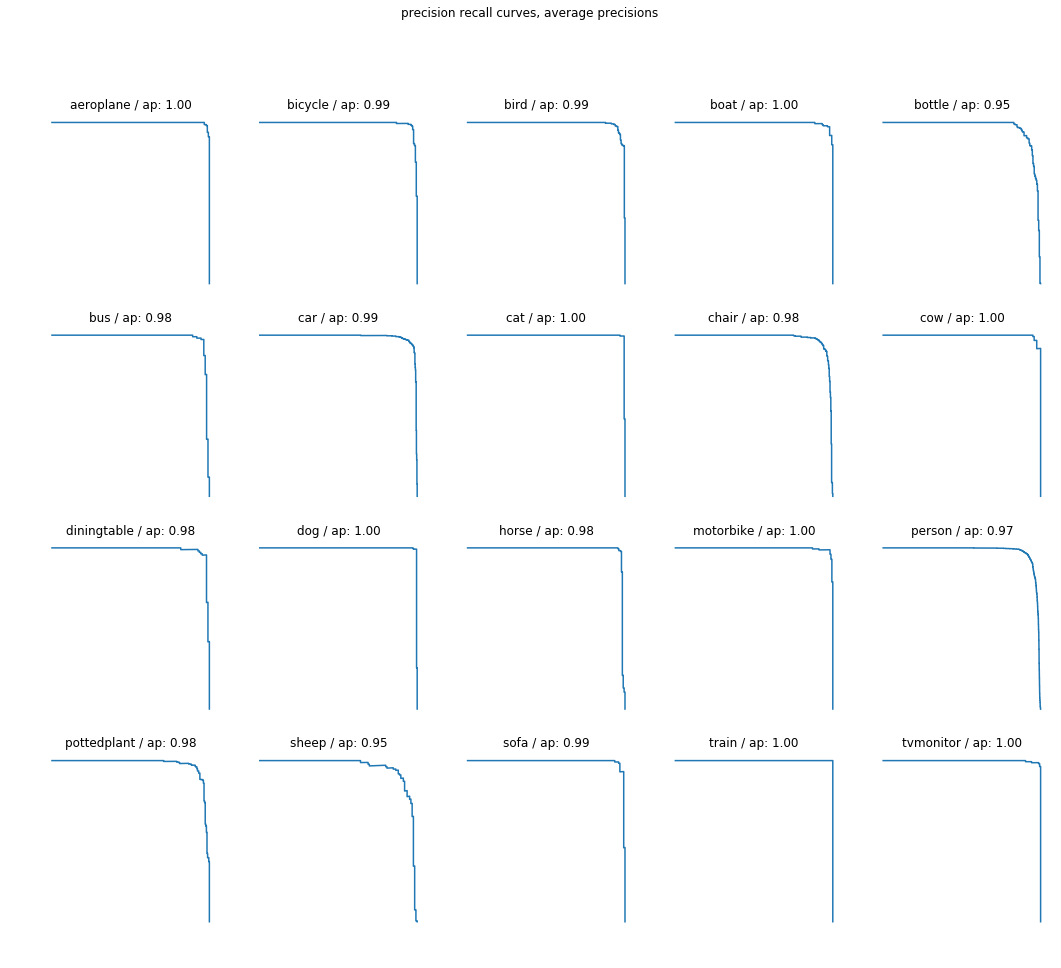

In [83]:
# inference

model.score_thresh = 0.0

gt_bboxes_all = []
gt_labels_all = []
pred_bboxes_all = []
pred_labels_all = []
pred_scores_all = []

for i in tqdm(range(len(valid_dataset))):
    
    img, gt_bboxes, gt_labels = valid_dataset[i]
    
    gt_bboxes_all.append(gt_bboxes)
    gt_labels_all.append(gt_labels)
    
    img = img[np.newaxis]
    pred_bboxes, pred_labels, pred_scores = model.predict(img)
    
    pred_bboxes_all.append(pred_bboxes[0])
    pred_labels_all.append(pred_labels[0])
    pred_scores_all.append(pred_scores[0])

# precision, recall, average precision
precs, recs = calc_detection_voc_prec_rec(pred_bboxes_all, pred_labels_all, pred_scores_all, gt_bboxes_all, gt_labels_all, iou_thresh=0.5)
average_precs = calc_detection_voc_ap(precs, recs)

# plot
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(18, 15))
axs = axs.flatten()

for i, cls_name in enumerate(voc_bbox_label_names):

    axs[i].plot(recs[i], precs[i])
    axs[i].set_title(cls_name+' / ap: {:.2f}'.format(average_precs[i]))
    axs[i].set_xlabel('recall')
    axs[i].set_ylabel('precision')
    axs[i].axis('off')
    
plt.suptitle('precision recall curves, average precisions')
plt.show()

In [14]:
!python --version

Python 3.6.3


In [15]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [16]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [17]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
